# This notebook shows the work done in order to obtain the accuracy score and the confusion matrix using Naive Guesser, Multinomial Naive Bayes and SGDClassifier models. Also, pre-processing and vectorization is done before fit in to a model. Steps are breifely explained. Combined data set from yelp, amazon and imdb is used to find the best performing model.

> Importing needed libraries

In [1]:
import pandas as pd
import matplotlib as plt
import string
import nltk
import re
import unicodedata
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nalindakulathunga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
filenames = ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']
with open('combined_reviews.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
            
Combined_DF = pd.read_csv("combined_reviews.txt", sep='\t', names = ["Review", "Label"])
Combined_DF = Combined_DF.sample(frac=1).reset_index(drop=True)

In [4]:
print Combined_DF.head(10)

                                              Review  Label
0    Obviously there is a problem with the adhesive.      0
1  The only good thing was our waiter, he was ver...      1
2              Just spicy enough.. Perfect actually.      1
3                  Thank you for such great service.      1
4             The shipping time was also very quick!      1
5                                Doesn't do the job.      0
6  The phone crashed completely and now I have to...      0
7  Shrimp- When I unwrapped it (I live only 1/2 a...      0
8  This is a very "right on case" movie that deli...      1
9                                 Waste of 13 bucks.      0


In [5]:
Combined_Df_RW = Combined_DF.drop('Label', axis=1)
Combined_Df_LB = Combined_DF["Label"]

In [6]:
print "\n___________ Reviews _____________\n"
print Combined_Df_RW.head(10)
print "\n___________ Labels _____________\n"
print Combined_Df_LB.head(10)


___________ Reviews _____________

                                              Review
0    Obviously there is a problem with the adhesive.
1  The only good thing was our waiter, he was ver...
2              Just spicy enough.. Perfect actually.
3                  Thank you for such great service.
4             The shipping time was also very quick!
5                                Doesn't do the job.
6  The phone crashed completely and now I have to...
7  Shrimp- When I unwrapped it (I live only 1/2 a...
8  This is a very "right on case" movie that deli...
9                                 Waste of 13 bucks.

___________ Labels _____________

0    0
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    1
9    0
Name: Label, dtype: int64


> Spliting data in to training and testing sets:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Combined_Df_RW, Combined_Df_LB, test_size=0.33, random_state=42)

In [8]:
print "\n___________ Training Reviews _____________\n"
print X_train.head()
print "\n___________ Training Labels _____________\n"
print y_train.head()


___________ Training Reviews _____________

                                                 Review
1094  In my house I was getting dropped coverage ups...
286   I have been in more than a few bars in Vegas, ...
1766              If you're not familiar, check it out.
300   sucked, most of the stuff does not work with m...
1456                               Good transmit audio.

___________ Training Labels _____________

1094    0
286     0
1766    1
300     0
1456    1
Name: Label, dtype: int64


In [9]:
print "\n___________ Testing Reviews _____________\n"
print X_test.head()
print "\n___________ Testing Labels _____________\n"
print y_test.head()


___________ Testing Reviews _____________

                                                 Review
2516                                   So Far So Good!.
2642  It is an hour and half waste of time, followin...
1359       It is a very well acted and done TV Movie.  
1702                                    Used and dirty.
2660  We had so much to say about the place before w...

___________ Testing Labels _____________

2516    1
2642    0
1359    1
1702    0
2660    0
Name: Label, dtype: int64


In [10]:
print "\nTraining data length:"
print len(X_train)
print "\nTesting data length:"
print len(X_test)


Training data length:
1841

Testing data length:
907


> Naive Guesser: (assuming all labels to be positive)

In [68]:
Y_pred_all_Pos = []

for i in range(len(X_test)):
    Y_pred_all_Pos.append(1)

print "length of the naively assumed list:"
print len(Y_pred_all_Pos)


length of the naively assumed list:
907


In [76]:
print "Accuracy with Naive guesser:"
print np.mean(Y_pred_all_Pos == y_test)

Accuracy with Naive guesser:
0.4994487320837927


In [77]:
from sklearn import metrics
print(metrics.classification_report(y_test, Y_pred_all_Pos, target_names="PN"))

             precision    recall  f1-score   support

          P       0.00      0.00      0.00       454
          N       0.50      1.00      0.67       453

avg / total       0.25      0.50      0.33       907



> Functions prepare words for lemmatizing

In [11]:
def strip_accents(text):
    """
    Remove accents from input String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def text_to_id(text):
    """
    Convert input text to id.
    """
    text = strip_accents(text.lower())
    text = re.sub('[ ]+', '_', text)
    text = re.sub('[^0-9a-zA-Z_-]', '', text)
    return text

> Pre-Processing

In [12]:
def PreProcess(InList = []):
    """
    This function gets an input list and remove punctuations, convers charactors to lower case and laso look for 
    any empty strings if available. Then it lemmatize the words. Returns a list with lemmatized sentences. 
    """
    X_List_nopunc = [''.join(c for c in s if c not in string.punctuation) for s in InList]
    X_List_nopunc_noempty = [s for s in X_List_nopunc if s]
    X_List_nopunc_noempty_nocaps = [x.lower() for x in X_List_nopunc_noempty]
    
    sent_list = []

    count = 0
    for item in range(len(InList)):
        count += 1
        word_string = ""
        for word in X_List_nopunc_noempty_nocaps[item][:].split(): 
            word_str = text_to_id(word)
            new_word = WordNetLemmatizer().lemmatize(word_str, 'v')
            word_string += str(new_word) + " "
        if word_string != "":
            sent_list.append(word_string)
    
    return sent_list

In [13]:
X_train_List = X_train["Review"].tolist()
X_train_List_cleaned = PreProcess(X_train_List)

X_test_List = X_test["Review"].tolist()
X_test_List_cleaned = PreProcess(X_test_List)

> Making a pipeline for the process with Multinomial Naive Bayes classifier:

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

In [52]:
text_clf.fit(X_train_List_cleaned, y_train) 

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
     ...False,
         use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [53]:
predicted = text_clf.predict(X_test_List_cleaned)
print "Accuracy with MultinomialNB:"
print np.mean(predicted == y_test)

Accuracy with MultinomialNB:
0.7960308710033076


In [54]:
print(metrics.classification_report(y_test, predicted, target_names="PN"))

             precision    recall  f1-score   support

          P       0.83      0.74      0.78       454
          N       0.77      0.85      0.81       453

avg / total       0.80      0.80      0.80       907



> Making a pipeline for the process with SGD Classifier:

In [55]:
from sklearn.linear_model import SGDClassifier
text_clf_2 = Pipeline([('vect_2', CountVectorizer(stop_words='english', ngram_range = (1, 1))),
                       ('tfidf_2', TfidfTransformer(use_idf=False)),
                       ('clf_2', SGDClassifier(loss='log', penalty='l2',
                                            alpha=1e-3, random_state=42))])

In [56]:
text_clf_2.fit(X_train_List_cleaned, y_train)
predicted_2 = text_clf_2.predict(X_test_List_cleaned)
print "Accuracy with SGD Classifier:"
print np.mean(predicted_2 == y_test)

Accuracy with SGD Classifier:
0.7783902976846747


In [57]:
print(metrics.classification_report(y_test, predicted_2, target_names="PN"))

             precision    recall  f1-score   support

          P       0.76      0.81      0.79       454
          N       0.80      0.74      0.77       453

avg / total       0.78      0.78      0.78       907



> Using GridSearchCV to find best parameters for SGDClassifier:

In [58]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect_2__ngram_range': [(1, 1), (1, 2)],
              'tfidf_2__use_idf': (True, False),
              'clf_2__alpha': (1e-2, 1e-3, 1e-4),
              'clf_2__loss': ('hinge', 'log')}

In [59]:
gs_clf = GridSearchCV(text_clf_2, parameters, n_jobs=-1)

In [60]:
y_train_List = y_train.tolist()
gs_clf = gs_clf.fit(X_train_List_cleaned[:500], y_train[:500])

In [61]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf_2__alpha: 0.001
clf_2__loss: 'log'
tfidf_2__use_idf: False
vect_2__ngram_range: (1, 1)


> Confusion metrix plotting:

In [62]:
import itertools
import numpy as np
import matplotlib.pyplot as pltpy

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pltpy.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    pltpy.imshow(cm, interpolation='nearest', cmap=cmap)
    pltpy.title(title)
    pltpy.colorbar()
    tick_marks = np.arange(len(classes))
    pltpy.xticks(tick_marks, classes, rotation=45)
    pltpy.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pltpy.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pltpy.tight_layout()
    pltpy.ylabel('True label')
    pltpy.xlabel('Predicted label')

> Confusion matrix with Naive Guesser:

Confusion matrix, without normalization
[[  0 454]
 [  0 453]]


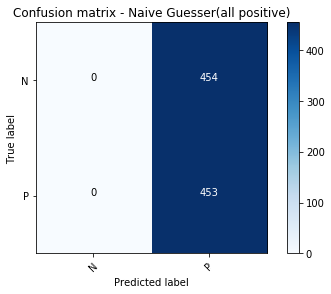

In [71]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix_NG = confusion_matrix(y_test, Y_pred_all_Pos)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pltpy.figure()
plot_confusion_matrix(cnf_matrix_NG, classes="NP",
                      title='Confusion matrix - Naive Guesser(all positive)')
pltpy.show()

> Confusion matrix for MultinomialNB:

Confusion matrix, without normalization
[[336 118]
 [ 67 386]]


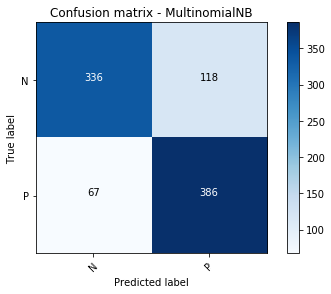

In [72]:
# Compute confusion matrix
cnf_matrix_NB = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pltpy.figure()
plot_confusion_matrix(cnf_matrix_NB, classes="NP",
                      title='Confusion matrix - MultinomialNB')
pltpy.show()

> Confusion metrix for SGD classifier:

Confusion matrix, without normalization
[[369  85]
 [116 337]]


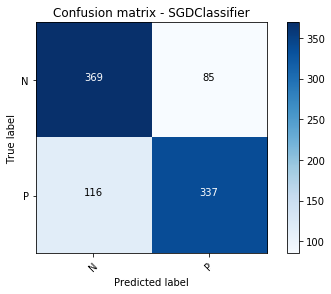

In [73]:
# Compute confusion matrix
cnf_matrix_SGD = confusion_matrix(y_test, predicted_2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pltpy.figure()
plot_confusion_matrix(cnf_matrix_SGD, classes="NP",
                      title='Confusion matrix - SGDClassifier')
pltpy.show()